## Landsat Image Segmentation 
The script shows an exmaple on using Python to explore a miltiple-band Landsat image scene and test segment the image with one scale mean-shift algorithm. Image was obtained using google earth engine javascript tool. Each pixel of each band represents the median value of surface reflectance of a subset of 2008 landuse image of Yolo County, California. The image is in EPSG 4326 projection. 
* [DWR landuse layer] (http://www.water.ca.gov/landwateruse/lusrvymain.cfm) is a vector file contains land parcel. It's used for indicating the boundary of farm lands in this area. 

In [1]:
%matplotlib inline
from __future__ import print_function 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from skimage.segmentation import felzenszwalb, quickshift
from skimage import io, exposure
import gdal
gdal.UseExceptions()
gdal.AllRegister()

In [2]:
def getPlotPara(imgFile):
    """
    Get plot parameters and image data for plotting raster maps and/or overlap a 
    shapefile with identical extent 
    """
    imgDs = gdal.Open(imgFile, gdal.GA_ReadOnly)
    bs = list()
    for b in range( imgDs.RasterCount ):
        b += 1
        bs.append(imgDs.GetRasterBand(b).ReadAsArray())
    
    img = np.dstack(bs)
    img[np.isnan(img)] = 0

    gt = imgDs.GetGeoTransform()
    proj = imgDs.GetProjection()

    xres = gt[1] 
    yres = gt[5] 

    xmin = gt[0] + xres * 0.5
    xmax = gt[0] + (xres * imgDs.RasterXSize - xres * 0.5)
    ymin = gt[3] + (yres * imgDs.RasterYSize + yres * 0.5)
    ymax = gt[3] - yres * 0.5 

    x_center=(xmin+xmax)/2
    y_center=(ymin+ymax)/2 

    return img, xmin, ymin, xmax, ymax, x_center, y_center

def normalize(arr, g):
    arr = exposure.rescale_intensity(arr, (arr.min(),arr.max()))
    return exposure.adjust_gamma(arr, g) # g: gamma range 0-1

imgFile = '/home/wryang/etdata/seg/yolo08_4326.tif'
img, xmin, ymin, xmax, ymax, x_center, y_center = getPlotPara(imgFile)
print('image data array shape {}'.format(img.shape))

image data array shape (1960, 2968, 6)


- Visualize reflectance frequency of each band

< Band # 1 >: 
Minimum=0.0, Maximum=3179.5, Mean=594.557426172, StdDev=249.48685966
< Band # 2 >: 
Minimum=0.0, Maximum=3908.5, Mean=975.464498147, StdDev=395.598743634
< Band # 3 >: 
Minimum=0.0, Maximum=4337.0, Mean=1142.47469064, StdDev=568.33374284
< Band # 4 >: 
Minimum=0.0, Maximum=6112.0, Mean=2721.01342061, StdDev=987.859921381
< Band # 5 >: 
Minimum=0.0, Maximum=5208.0, Mean=2225.97390603, StdDev=902.460332471
< Band # 6 >: 
Minimum=0.0, Maximum=6604.0, Mean=1451.41837787, StdDev=676.369867434


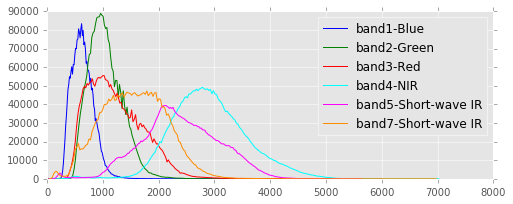

In [3]:
imgL5 = '/home/wryang/etdata/seg/yolo08_4326.tif'
imgDs = gdal.Open(imgL5, gdal.GA_ReadOnly)
for band in range( imgDs.RasterCount ):
    band += 1
    print ('< Band # {} >: '.format(band))
    bands = imgDs.GetRasterBand(band)
    if bands is None:
        continue

    stats = bands.GetStatistics( True, True )
    if stats is None:
        continue

    print('Minimum={}, Maximum={}, Mean={}, StdDev={}'.format( stats[0], stats[1], stats[2], stats[3] ))

plt.style.use('ggplot')
fig = plt.figure(figsize=(8, 3))
fig.set_facecolor('white')

for color, channel, labels in zip(['blue','green','red','cyan','magenta','darkorange'], \
            np.rollaxis(img, axis=-1), 
            ['band1-Blue','band2-Green','band3-Red','band4-NIR','band5-Short-wave IR','band7-Short-wave IR']):
    counts, centers = exposure.histogram(channel)
    plt.plot(centers[1::], counts[1::], color=color, label=labels)

plt.legend( loc='upper right', numpoints = 1 )
plt.show()

- Create a rectangle polygon to clip a subset for mapping

In [4]:
from shapely.geometry import mapping, box
import fiona
from fiona.crs import from_epsg

# Use point locaiton to create a polygon -- around the center of the entire map
poly = box(x_center, y_center-0.08, x_center+0.15, y_center+0.08, ccw=True)

# Define a polygon feature geometry with a id attribute 
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
    }

# Write a new Shapefile
with fiona.open('/home/wryang/etdata/seg/yo08/aoi.shp', 'w', crs=from_epsg(4326), driver='ESRI Shapefile', schema=schema) as c:
    c.write({
            'geometry': mapping(poly),
            'properties': {'id': 1},
        })

In [5]:
#! ogr2ogr -clipsrc /home/wryang/etdata/seg/yo08/aoi.shp /home/wryang/etdata/seg/yo08/t08yo_aoi.shp /home/wryang/etdata/seg/yo08/t08yo.shp
#! gdalwarp -of GTiff -cutline /home/wryang/etdata/seg/yo08/aoi.shp -crop_to_cutline /home/wryang/etdata/seg/yolo08_4326.tif /home/wryang/etdata/seg/yolo08_aoi.tif

- How the satellite image looking like on parcel map

Landsat image overlaid with DWR landuse layer


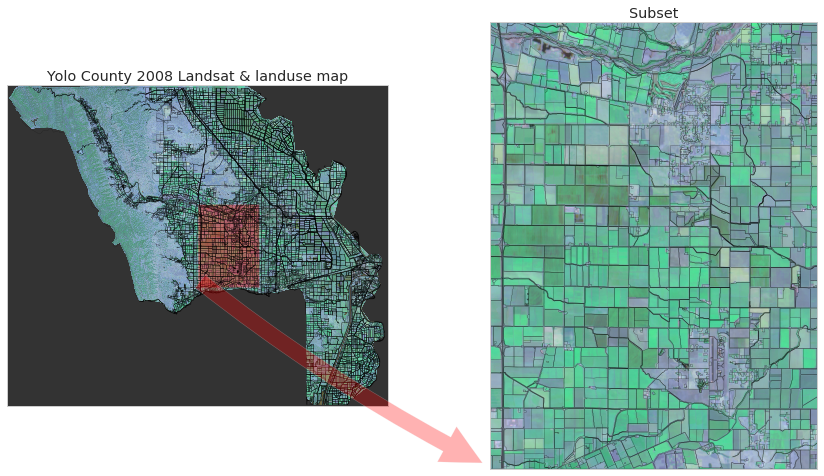

In [6]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(121)
ax1.set_title('Yolo County 2008 Landsat & landuse map')

# Normalize the image to fit rgb DN range
# img1 = np.dstack((normalize(img[:,:,4], 0.65), normalize(img[:,:,3], 0.7), normalize(img[:,:,2], 0.6))) 
img1 = np.dstack((normalize(img[:,:,4], 0.65), normalize(img[:,:,3], 0.65), normalize(img[:,:,2], 0.7) ) ) 
# Flip the image since the raster were read from top-left and Basemap use lower-left
img1 = np.dstack((np.flipud(img1[:,:,2]), np.flipud(img1[:,:,1]), np.flipud(img1[:,:,0])))

m = Basemap(projection='tmerc', 
              lat_0=y_center, lon_0=x_center,
              llcrnrlon=xmin, 
              llcrnrlat=ymin, 
              urcrnrlon=xmax, 
              urcrnrlat=ymax, 
              resolution='c')
m.readshapefile('/home/wryang/etdata/seg/yo08/t08yo','yolo08',drawbounds=True, linewidth=0.1)
m.imshow(img1, alpha=0.8) 

ptList = [m(x_center, y_center-0.08), m(x_center, y_center+0.08),\
            m(x_center+0.15, y_center+0.08), m(x_center+0.15, y_center-0.08)]
poly = Polygon( ptList, facecolor='red', alpha=0.4 )
plt.gca().add_patch(poly)

# Plot the subset
img2, xmin2, ymin2, xmax2, ymax2, x_center2, y_center2 = getPlotPara('/home/wryang/etdata/seg/yolo08_aoi.tif')
img2 = np.dstack((normalize(img2[:,:,4], 0.65), normalize(img2[:,:,3], 0.65), normalize(img2[:,:,2], 0.7))) 
img2 = np.dstack((np.flipud(img2[:,:,2]), np.flipud(img2[:,:,1]), np.flipud(img2[:,:,0])))
ax2 = fig.add_subplot(122)
ax2.set_title('Subset')
m2 = Basemap(projection='tmerc', 
              lat_0=y_center2, lon_0=x_center2,
              llcrnrlon=xmin2, 
              llcrnrlat=ymin2, 
              urcrnrlon=xmax2, 
              urcrnrlat=ymax2, 
              resolution='c')
m2.readshapefile('/home/wryang/etdata/seg/yo08/t08yo_aoi','yolo08b',drawbounds=True, linewidth=0.1)
m2.imshow(img2, alpha=0.8) 

# Create an arrow point from the ca map to the subset
# Set transformation operators
ax0tr = ax1.transData # Axis 0 -> Display
ax1tr = ax2.transData # Axis 1 -> Display
figtr = fig.transFigure.inverted() # Display -> Figure
# Transform arrow start/end point from axis 0 to figure coordinates
ptB = figtr.transform(ax0tr.transform((41000, 29000)))
ptE = figtr.transform(ax1tr.transform((700, 200)))
# Create the patch
arrow = matplotlib.patches.FancyArrowPatch(
    ptB, ptE, transform=fig.transFigure,  # Place arrow in figure coord system
    fc = 'r', connectionstyle='arc3,rad=0.05', arrowstyle='simple', alpha = 0.3,
    mutation_scale = 80.)
# Add patch to list of objects to draw onto the figure
fig.patches.append(arrow) 

print('Landsat image overlaid with DWR landuse layer')
plt.show()

- Test segmentation on a subset

(200, 200)


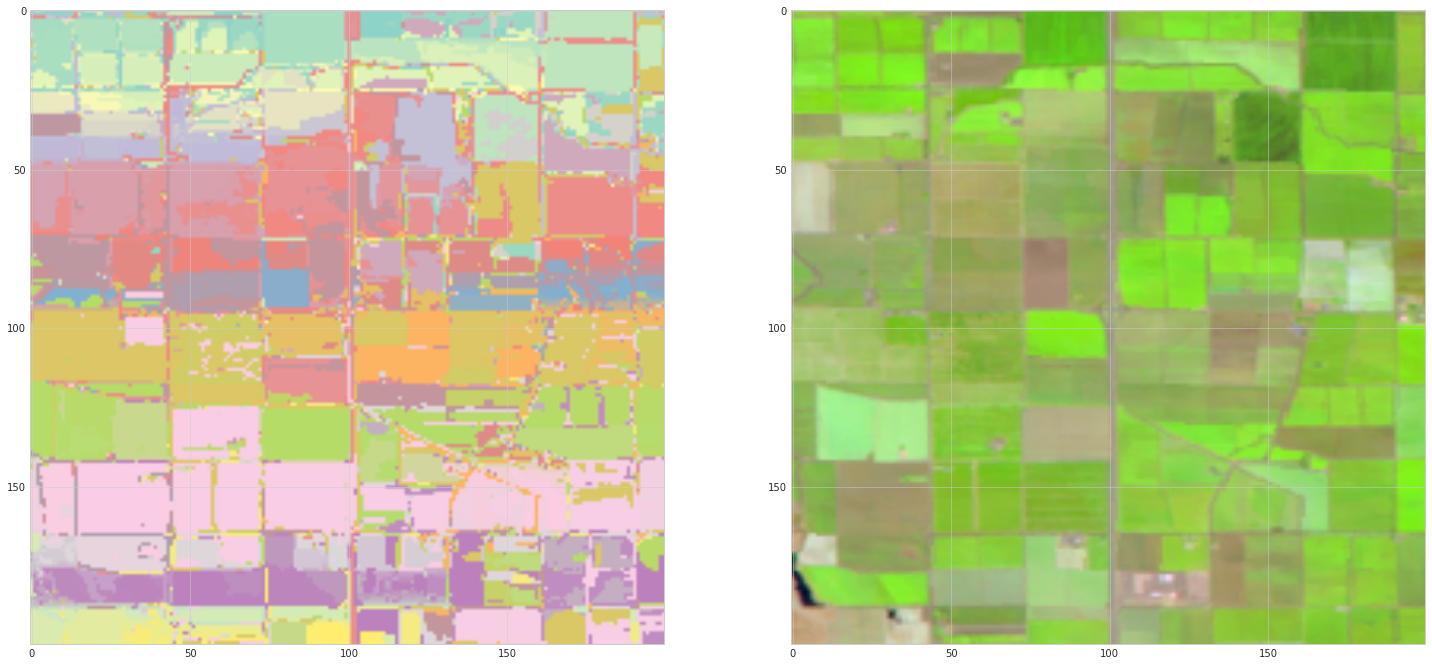

In [7]:
imgS = img[1000:1200, 1400:1600, :]
segMS = quickshift(imgS, kernel_size=35, convert2lab=False, max_dist=92, ratio=0.61)
print(segMS.shape)

img_sub = np.dstack((normalize(imgS[:,:,4], 0.65), normalize(imgS[:,:,3], 0.65), normalize(imgS[:,:,2], 0.7) ) ) 

fig = plt.figure(figsize=(25, 12))
plt.subplot(121)
plt.imshow(segMS, cmap=plt.get_cmap('Set3'))

plt.subplot(122)
plt.imshow(img_sub)